# Recurrent Soft Actor-Critic

This notebooks runs different test trials of the fully recurrent version of the Soft Actor-Critic. The test are run on the straight line stabilization tasks.

### Import libraries

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm
# from IPython.display import clear_output
# import matplotlib.animation as animation
# from matplotlib.gridspec import GridSpec
import pickle

# import local libraries
from environments.linear import Linear_SDI
from src.SoftActorCriticRNN.main_RNN import SACAgent
from src.utilities.run_trial import run_trial

## SAC - WilsonCowan recurrence

Instance of the stochastic double integrator with full observability.

In [2]:
# PARAMETERS
gamma = 1

memory_size = 2200
batch_size = 128
initial_random_steps = 200

hidden_size = 32
history_size = 12
control_limit = 4.
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 4
Nep = 3000
name = 'SAC_WC'

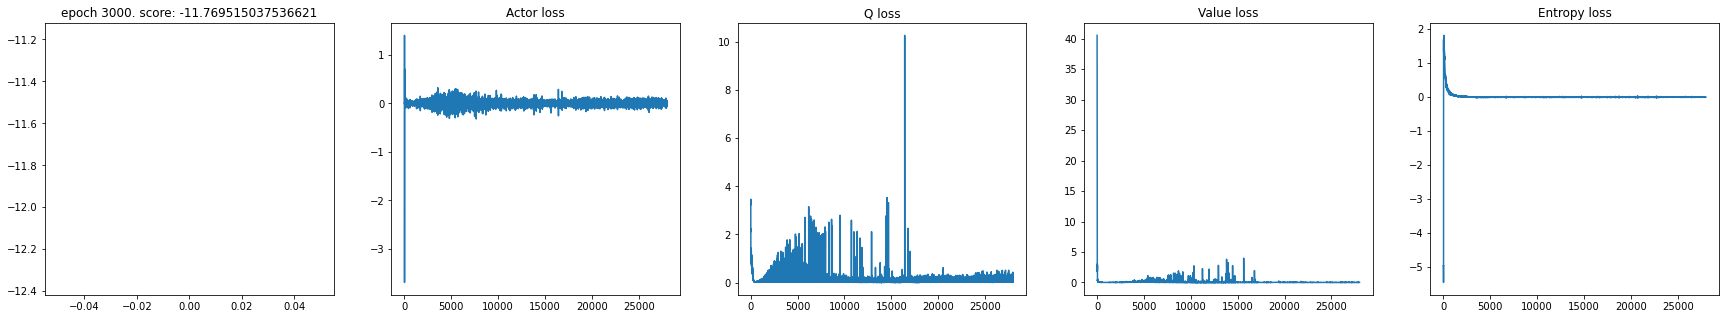

In [3]:
# RUN
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(idx)
    key = jrandom.PRNGKey(idx)

    env = Linear_SDI(end_time=20)
    env.v = jnp.identity(2) * 0
    env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        lr_q=1e-3,
        memory_decay=5e-3,
        gamma=gamma,
        history_size=history_size,
        hidden_size=hidden_size
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}

In [3]:
filename = f'models/0331/SACRNN_OO_fully_observable.pickle'

"""Save params"""
# with open(filename, 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)

"""Import params"""
with open(filename, 'rb') as handle:
    PARAMS = pickle.load(handle)


### Results

In [4]:
env = Linear_SDI(end_time=20)
env.v = jnp.identity(2) * 0
env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

N = 10

x_space = np.linspace(-10, 10, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

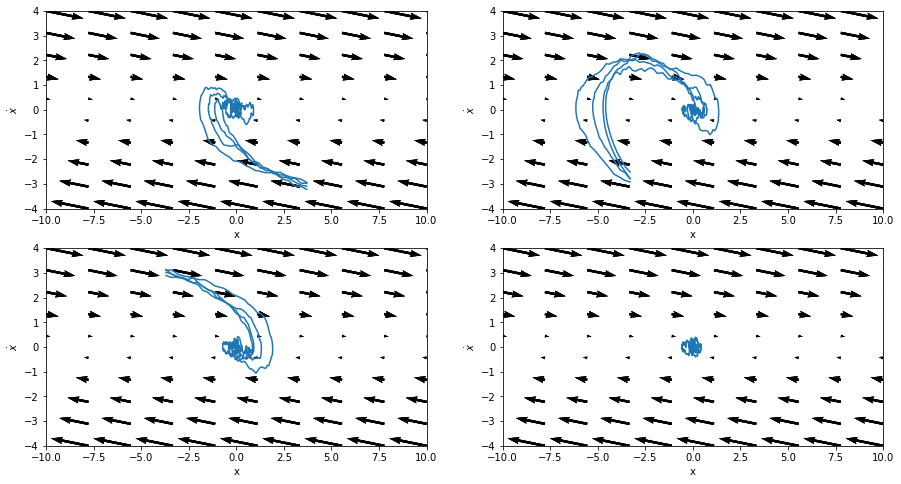

In [6]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi'].predict_step
    for pidx in range(4):
        S, Y, U = run_trial(env, controller, T=15, x0=x0[pidx], recurrent=True, hidden_size=hidden_size)
        ax[pidx].quiver(xv, vv, qx, qv)
        ax[pidx].plot(S[:,0], S[:,1], c='tab:blue')

for idx in range(4):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
plt.show()

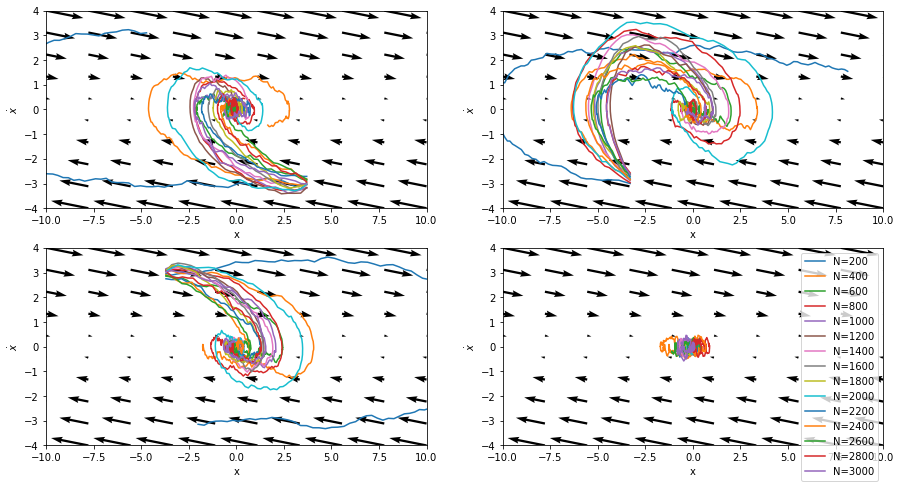

In [9]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for factor in range(1, int(Nep/200)+1):
    controller = PARAMS[name][0][f'N{factor*200}']['pi'].predict_step
    for pidx in range(4):
        S, Y, _ = run_trial(env, controller, T=15, x0=x0[pidx], recurrent=True, hidden_size=hidden_size)        
        ax[pidx].plot(S[:,0], S[:,1], label=f'N={factor*200}')

for idx in range(4):
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
ax[-1].legend()
plt.show()

## SAC - WilsonCowan recurrence - partial observability

Now the effect of noisy observations is tested. The system is run and tested under different noise levels.

In [10]:
# PARAMETERS
gamma = 1

memory_size = 2200
batch_size = 128
initial_random_steps = 200

hidden_size = 32
history_size = 12
control_limit = 4.
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 5
Nep = 3000
name = 'SAC_WC_PO'

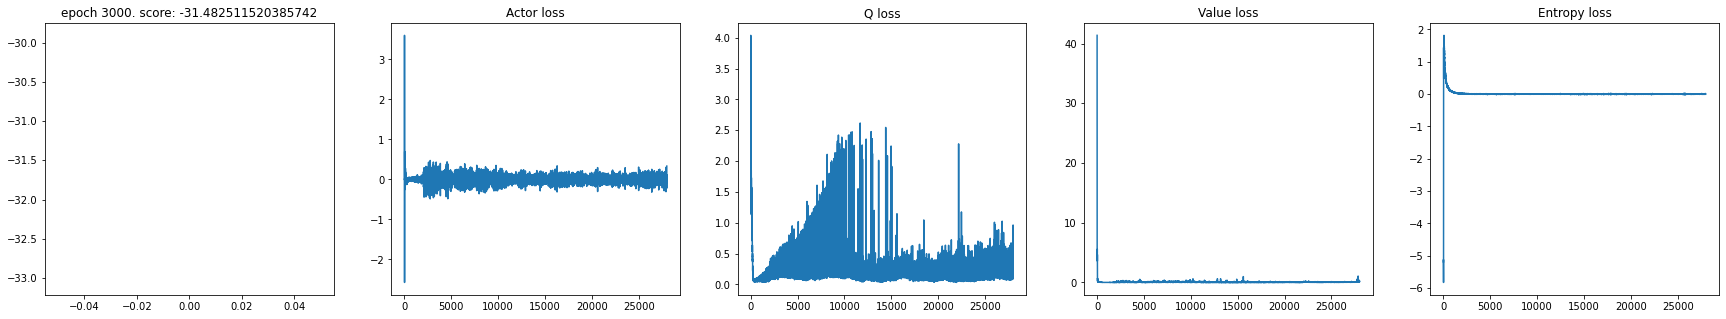

In [8]:
# RUN
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(0)
    key = jrandom.PRNGKey(0)

    env = Linear_SDI(end_time=20)
    env.v = jnp.identity(2) * idx/10
    env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        lr_q=1e-3,
        memory_decay=5e-3,
        gamma=gamma,
        history_size=history_size,
        hidden_size=hidden_size
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}


In [11]:
filename = f'models/0331/SACRNN_OO_partially_observable.pickle'

"""Save params"""
# with open(filename, 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)

"""Import params"""
with open(filename, 'rb') as handle:
    PARAMS = pickle.load(handle)


### Results

In [12]:
state_scale = 5

env = Linear_SDI(end_time=20)
env.v = jnp.identity(2) * 0
env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

N = 10

x_space = np.linspace(-10, 10, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

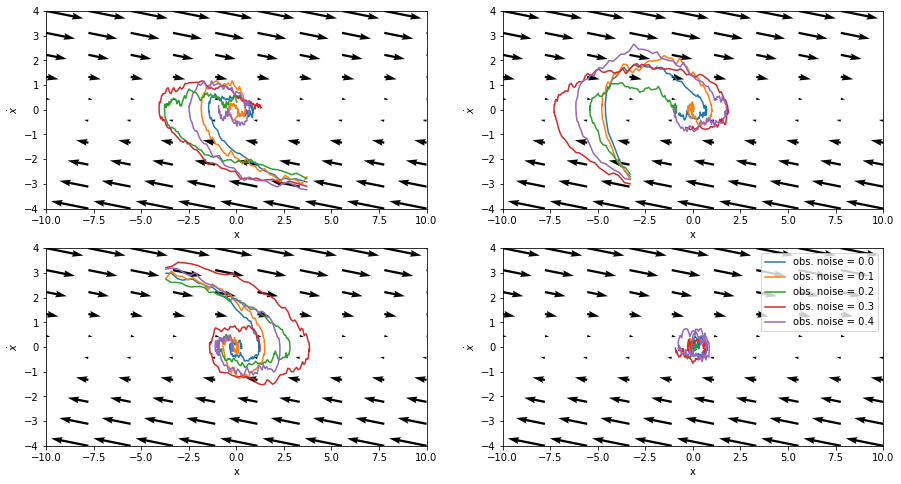

In [13]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi'].predict_step
    for pidx in range(4):
        env.v = jnp.identity(2) * idx/10
        S, Y, _ = run_trial(env, controller, T=15, x0=x0[pidx], recurrent=True, hidden_size=hidden_size)
        ax[pidx].plot(S[:,0], S[:,1], label=f'obs. noise = {idx/10:.1f}')

for idx in range(4):
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
ax[-1].legend()
plt.show()

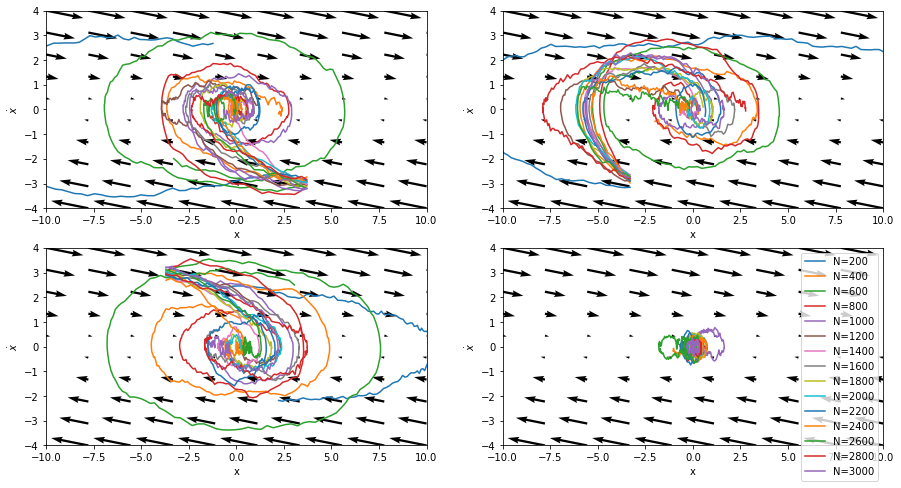

In [14]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for factor in range(1, int(Nep/200)+1):
    controller = PARAMS[name][-1][f'N{factor*200}']['pi'].predict_step
    for pidx in range(4):
        env.v = jnp.identity(2) * .4
        S, Y, _ = run_trial(env, controller, T=15, x0=x0[pidx], recurrent=True, hidden_size=hidden_size)
        ax[pidx].plot(S[:,0], S[:,1], label=f'N={factor*200}')

for idx in range(4):
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
ax[-1].legend()
plt.show()